## APPLICATION DU CLUSTRING AVEC DBSCAN  (Density-Based Spatial Clustering of Applications with Noise) 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd

### Génération et préparation du dataset

In [13]:

# Génération du jeu de données "make_moons"
noise=0.05
X, y = make_moons(n_samples=200, noise=noise, random_state=42)

# Mettre les données à l'échelle (Standardization)
# C'est souvent crucial pour les algorithmes basés sur la distance comme DBSCAN
X = StandardScaler().fit_transform(X)


### Analyse exploratoire des données

    Pour DBSCAN (votre cas), l'algorithme dépend fortement de la notion de distance (ϵ). Si les échelles ne sont pas uniformes, la distance calculée sera faussée et le clustering sera inefficace.

    La standardisation garantit qu'une variation d'une unité dans Feature_1 a le même poids qu'une variation d'une unité dans Feature_2.

    Gérer les Outliers (dans une certaine mesure) : Bien que la standardisation ne supprime pas les valeurs aberrantes, elle les met en évidence. Les points ayant un Z-score très élevé (typiquement ∣z∣>3) sont des candidats potentiels pour des valeurs extrêmes.

--- 1. Aperçu et Structure du Dataset ---
Forme du jeu de données (X) : (200, 2)
Aperçu du DataFrame :
   Feature_1  Feature_2  Target Target_Name
0  -1.745663  -0.308449       0           0
1   0.462854   0.403861       0           0
2   0.133380   1.008798       0           0
3   0.831851  -1.381347       1           1
4  -0.197999  -0.940142       1           1
           count          mean       std       min       25%       50%  \
Feature_1  200.0  1.154632e-16  1.002509 -1.837232 -0.632412 -0.003891   
Feature_2  200.0 -7.549517e-17  1.002509 -1.663212 -0.925972 -0.012172   

                75%       max  
Feature_1  0.582280  1.791799  
Feature_2  0.890117  1.713698  


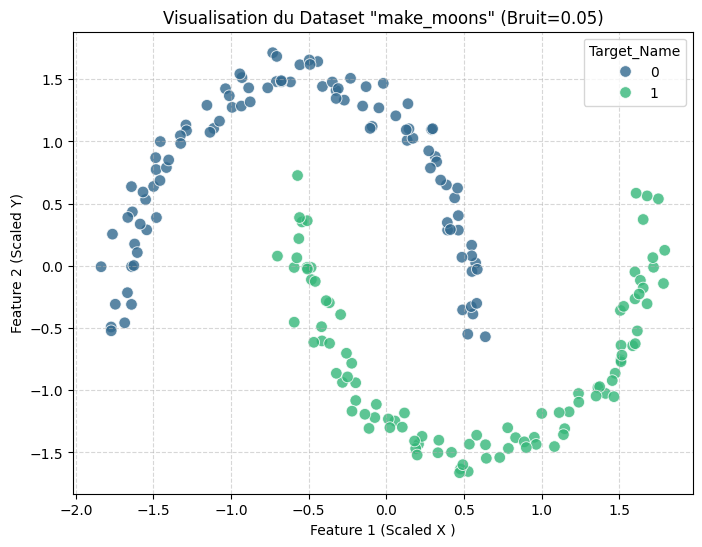

In [18]:



# Création d'un DataFrame pour faciliter l'EDA avec Pandas et Seaborn
df_moons = pd.DataFrame(X, columns=['Feature_1', 'Feature_2'])
df_moons['Target'] = y # La cible (labels "réels") est utile pour la visualisation
df_moons['Target_Name'] = df_moons['Target'].astype(str) # C'est simplement la colonne Target convertie en chaîne de caractères (str) pour faciliter l'affichage dans les graphiques Seaborn.

print("--- 1. Aperçu et Structure du Dataset ---")
print(f"Forme du jeu de données (X) : {X.shape}")
print("Aperçu du DataFrame :")
print(df_moons.head())

# --- 2. Statistiques Descriptives ---
# Après standardisation, la moyenne est proche de 0 et l'écart-type de 1 signifiant que les deux caractéristiques contribuent de manière égale à la mesure de la distance (comme la distance euclidienne)
# min/max :la valeur minimale observée pour chaque caractéristique.
# 50%: Ces sont les quartiles. Ils montrent la répartition des données. Par exemple, 50% des valeurs de Feature_1 sont inférieures à -0.003891.

("\n--- 2. Statistiques Descriptives (Après Scaling) ---")
print(df_moons[['Feature_1', 'Feature_2']].describe().T) # describe donne 


# --- 4. Visualisation Clé du Dataset ---
plt.figure(figsize=(8, 6))

# Nuage de points des deux caractéristiques, coloré par la cible (labels réels)
sns.scatterplot(
    x='Feature_1', 
    y='Feature_2', 
    hue='Target_Name', 
    data=df_moons, 
    palette='viridis', 
    legend='full',
    alpha=0.8,
    s=70 # Taille des points
)

plt.title(f'Visualisation du Dataset "make_moons" (Bruit={noise})')
plt.xlabel('Feature 1 (Scaled X )')
plt.ylabel('Feature 2 (Scaled Y)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show() #

## Application de l'algorithme DBSCAN 
* Initialisation de DBSCAN avec des paramètres typiques
* eps (epsilon) : La distance maximale entre deux échantillons pour qu'un échantillon soit considéré comme étant dans le voisinage de l'autre.
* min_samples : Le nombre d'échantillons dans un voisinage pour qu'un point soit (ce qui equivaut à min-point)
* considéré comme un point central (core point).


In [16]:
db = DBSCAN(eps=0.3, min_samples=5)

# Entraînement du modèle
db.fit(X)

DBSCAN(eps=0.3)

## Récupéreration les étiquettes de cluster.
#### L'étiquette -1 indique les points considérés comme du bruit.

In [5]:

labels = db.labels_

# Nombre de clusters dans les étiquettes, en ignorant le bruit (-1)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f"Nombre de clusters estimés : {n_clusters_}")
print(f"Nombre de points de bruit estimés : {n_noise_}")


Nombre de clusters estimés : 2
Nombre de points de bruit estimés : 1


## Visualisation des résultats

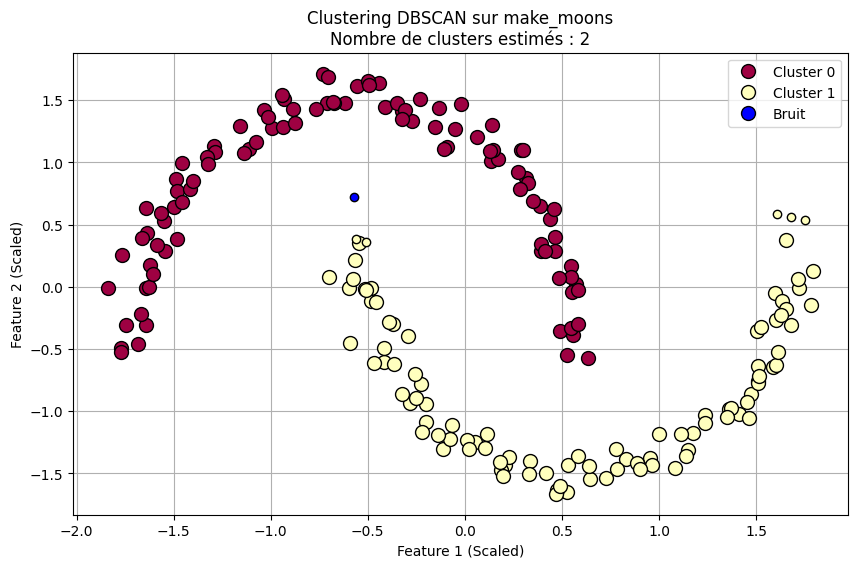

In [25]:

plt.figure(figsize=(10, 6))

# Récupérer un masque pour les points centraux (core points)
core_samples_mask = np.zeros_like(labels, dtype=bool)
#Crée un masque booléen (True/False) de la même taille que les données. Les valeurs sont True pour les indices qui correspondent aux points centraux (core points) identifiés par DBSCAN (db.core_sample_indices_)
core_samples_mask[db.core_sample_indices_] = True 

# Déterminer les couleurs uniques pour chaque cluster
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

# Tracer chaque cluster
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Si l'identifiant est -1, c'est du bruit
        col = [0, 0, 1, 1]

    class_member_mask = (labels == k)

    # Tracer les points centraux (Core points)
    #Sélectionne les points qui sont à la fois dans le cluster actuel (class_member_mask) ET sont des points centraux (core_samples_mask). Ils sont tracés avec une grande taille (markersize=10) pour les mettre en évidence.
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10, label=f'Cluster {k}' if k != -1 else 'Bruit')

    # Tracer les points de bordure (Border points)
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title(f'Clustering DBSCAN sur make_moons\nNombre de clusters estimés : {n_clusters_}')
plt.xlabel('Feature 1 (Scaled)')
plt.ylabel('Feature 2 (Scaled)')
plt.legend()
plt.grid(True)
plt.show()